# Loading Le Petit Prince data
_by Marianne de Heer Kloots, Oct 2022 (last edited: Apr 2023)_

(for [Advanced Neural & Cognitive Modelling](https://clclab.github.io/ANCM/intro.html))

Some example code for downloading and dealing with data from the [Le Petit Prince](https://openneuro.org/datasets/ds003643/versions/2.0.1) multilingual naturalistic fMRI corpus ([Li et al., 2022](https://doi.org/10.1038/s41597-022-01625-7)).

In [4]:
!pip install ipywidgets matplotlib

  Using cached matplotlib-3.7.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.2 MB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached contourpy-1.0.7-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached fonttools-4.39.3-py3-none-any.whl (1.0 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached Pillow-9.5.0-cp38-cp38-manylinux_2_28_x86_64.whl (3.4 MB)


In [2]:
# download this library to deal with openneuro data
!pip install -q openneuro-py
# this is for dealing with neuroimaging data
!pip install nilearn
# this is for dealing with Praat TextGrids
!pip install tgt

In [4]:
from nilearn import datasets, image, masking, plotting, regions
import openneuro as on
import pandas as pd
import numpy as np
import tgt
import glob

In [5]:
subjects = ['sub-CN001', 'sub-CN002', 'sub-EN057', 'sub-EN058', 'sub-FR001', 'sub-FR002']
N_sections = 9

In [6]:
# here's how you load an fMRI file using  nilearn
fmri_file_1 = '/project/gpuuva021/shared/FMRI-Data/derivatives/sub-EN057/func/sub-EN057_task-lppEN_run-15_space-MNIColin27_desc-preproc_bold.nii.gz'
nii_img_1  = image.load_img(fmri_file_1)
nii_data_1 = nii_img_1.get_fdata()

You can get some info from the [image header](https://nipy.org/nibabel/reference/nibabel.nifti1.html#nibabel.nifti1.Nifti1Header), like the below: voxels are 2x2x2mm, TR is 2 seconds

In [7]:
print(nii_img_1.header.get_zooms())
print(nii_img_1.header.get_xyzt_units())

(2.0, 2.0, 2.0, 2.0)
('mm', 'sec')


In [8]:
# you get a 73x90x74 volume for every TR; 
# there are 282 TRs in this run (= 564 seconds, checks out with the length of section 1, see below)
nii_data_1.shape

(73, 90, 74, 282)

We load another fMRI file for the same section & language, to check that it indeed has the same number of TRs (note that loading these fMRI files takes quite a bit of disk space, you probably shouldn't actually ever have more than 1 file loaded into memory at once)

In [12]:
fmri_file_2 = '/project/gpuuva021/shared/FMRI-Data/derivatives/sub-EN058/func/sub-EN058_task-lppEN_run-08_space-MNIColin27_desc-preproc_bold.nii.gz'

nii_img_2  = image.load_img(fmri_file_2)
nii_data_2 = nii_img_2.get_fdata()

In [13]:
nii_data_2.shape

(73, 90, 74, 282)

Check one fMRI file for Chinese and French:

In [14]:
fmri_file_3 = '/project/gpuuva021/shared/FMRI-Data/derivatives/sub-CN001/func/sub-CN001_task-lppCN_run-04_space-MNIColin27_desc-preproc_bold.nii.gz'
nii_img_3  = image.load_img(fmri_file_3)
nii_data_3 = nii_img_3.get_fdata()

In [15]:
# Chinese
nii_data_3.shape

(73, 90, 74, 283)

In [11]:
fmri_file_4 = '/project/gpuuva021/shared/FMRI-Data/derivatives/sub-FR001/func/sub-FR001_task-lppFR_run-01_space-MNIColin27_desc-preproc_bold.nii.gz'
nii_img_4 = image.load_img(fmri_file_4)
nii_data_4 = nii_img_4.get_fdata()

In [12]:
# French
nii_data_4.shape

(73, 90, 74, 309)

The fMRI data for the first section has volumes for 282, 283, and 309 TRs for English, Chinese and French respectively.
That's (nTRs*2) 564, 566, and 618 s of recordings.

Compared to the word presentation times in the tables below, it seems that there are 5 and 3 extra TRs resp. for the English and French data, but none for the Chinese.. 

In [18]:
# English word information
en_words = pd.read_csv('/project/gpuuva021/shared/FMRI-Data/annotation/EN/lppEN_word_information.csv',
                       index_col=[0])
en_words[en_words['section'] == 1]

,word,lemma,onset,offset,logfreq,pos,section,top_down,bottom_up,left_corner
0,once,once,0.113,0.728,5.824406,ADV,1,3,1,2
1,when,when,0.728,0.919,7.562214,ADV,1,2,2,2
2,i,i,0.919,1.025,8.500759,PRON,1,3,2,3
3,was,was,1.025,1.158,8.848911,AUX,1,2,1,2
4,six,six,1.158,1.464,5.208940,NUM,1,3,1,2
...,...,...,...,...,...,...,...,...,...,...
1512,you,you,553.556,553.656,7.992843,PRON,1,2,2,2
1513,can,can,553.656,553.966,7.653732,VERB,1,2,1,2
1514,t,not,553.966,553.995,8.652790,PART,1,1,1,1
1515,go,go,553.995,554.186,6.016645,VERB,1,2,1,2


In [19]:
# French word information
fr_words = pd.read_csv('/project/gpuuva021/shared/FMRI-Data/annotation/FR/lppFR_word_information.csv',
                       index_col=[0])
fr_words[fr_words['section'] == 1]

,word,lemma,onset,offset,logfreq,pos,section,top_down,bottom_up,left_corner
0,lorsque,lorsque,3.05,3.42,1.693375,CS,1,3,1,2
1,j',j',3.42,3.44,-5.958607,CLS,1,2,1,2
2,avais,avais,3.53,3.76,2.895069,V,1,1,3,2
3,six,six,3.93,4.18,2.069557,DET,1,2,1,2
4,ans,ans,4.18,4.36,2.856227,NC,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...
1627,peut,peut,609.51,609.65,3.082656,V,1,1,2,2
1628,pas,pas,609.65,609.87,4.262812,ADV,1,1,1,1
1629,aller,aller,609.87,610.04,2.921150,VINF,1,3,2,3
1630,bien,bien,610.04,610.20,3.637258,ADV,1,2,1,2


In [20]:
# Chinese word information
cn_words = pd.read_csv('/project/gpuuva021/shared/FMRI-Data/annotation/CN/lppCN_word_information.csv',
                       index_col=[0])
cn_words[cn_words['section'] == 1]

,word,lemma,onset,offset,logfreq,pos,section,top_down,bottom_up,left_corner
0,当,当,0.00,0.14,8.529403,ADP,1,3,1,2
1,我,我,0.14,0.25,10.534098,PRON,1,5,2,3
2,还,还,0.25,0.43,9.872624,ADV,1,3,2,3
3,只有,只有,0.43,0.67,8.511888,ADV,1,2,1,2
4,六,六,0.67,0.89,8.930712,NUM,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...
1748,不会,不会,563.79,564.16,0.597187,VERB,1,3,2,3
1749,走,走,564.16,564.35,7.984939,VERB,1,3,2,3
1750,出,出,564.35,564.50,9.616850,VERB,1,4,1,2
1751,多,多,564.50,564.69,9.815064,ADV,1,1,3,2


# Preparing brain features

Below are some things you'll need to get the fMRI data into the right format for your analyses.

(Just some example code for the French fMRI data, i.e. `nii_img_4`)

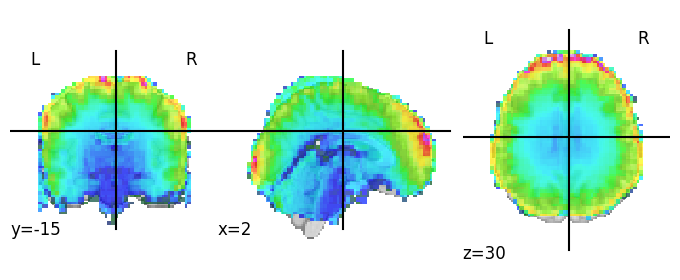

In [19]:
# this is the mean signal over all recorded volumes (all TRs (Times)), plotted over a standard MNI space template
func_mean = image.mean_img(nii_img_4)
display = plotting.plot_roi(func_mean)

### Masking: option 1

You'll need to mask the volumes to get a flat feature vector for each TR; here's a basic function that will do for whole brain analyses (see [compute_epi_mask](https://nilearn.github.io/dev/modules/generated/nilearn.masking.compute_epi_mask.html) in the nilearn docs). 

If you want to do this, it'll be wise to run PCA on these vectors first to reduce the dimensionality and make further computations (like distance or correlation measures) managable.

In [22]:
func_mask = masking.compute_epi_mask(func_mean)
nii4_masked = masking.apply_mask(nii_img_4, func_mask)
nii4_masked.shape # time (TR) x mask_dim

# nii4_masked[0][:25]

(309, 247619)

: 

### Masking: option 2 (tentative)

You can also use a mask to extract only voxels from a particular ROI.

NB: Need to check that the atlas and dataset spaces are aligned for this to work, which I'm not fully sure of, but feel free to try / use this for your miniproject regardless.

[(1, 'Background'), (2, 'Frontal Pole'), (3, 'Insular Cortex'), (4, 'Superior Frontal Gyrus'), (5, 'Middle Frontal Gyrus'), (6, 'Inferior Frontal Gyrus, pars triangularis'), (7, 'Inferior Frontal Gyrus, pars opercularis'), (8, 'Precentral Gyrus'), (9, 'Temporal Pole'), (10, 'Superior Temporal Gyrus, anterior division'), (11, 'Superior Temporal Gyrus, posterior division'), (12, 'Middle Temporal Gyrus, anterior division'), (13, 'Middle Temporal Gyrus, posterior division'), (14, 'Middle Temporal Gyrus, temporooccipital part'), (15, 'Inferior Temporal Gyrus, anterior division'), (16, 'Inferior Temporal Gyrus, posterior division'), (17, 'Inferior Temporal Gyrus, temporooccipital part'), (18, 'Postcentral Gyrus'), (19, 'Superior Parietal Lobule'), (20, 'Supramarginal Gyrus, anterior division'), (21, 'Supramarginal Gyrus, posterior division'), (22, 'Angular Gyrus'), (23, 'Lateral Occipital Cortex, superior division'), (24, 'Lateral Occipital Cortex, inferior division'), (25, 'Intracalcarine C

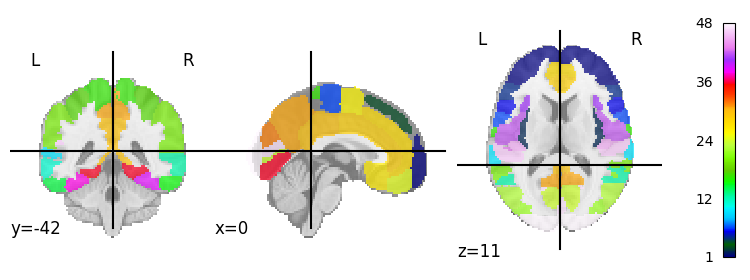

In [10]:
ho_maxprob_atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
ho_maxprob_atlas_img = image.load_img(ho_maxprob_atlas['maps'])

# ROI numbers & text labels in this atlas
print([(i+1, roi) for i, roi in enumerate(ho_maxprob_atlas['labels'])])
display = plotting.plot_roi(ho_maxprob_atlas_img, colorbar=True)

In [13]:
# resample the atlas to the dataset resolution
ho_maxprob_atlas_img_resamp = image.resample_to_img(
    ho_maxprob_atlas_img,
    target_img=nii_img_4,
    interpolation='nearest'
)

In [14]:
# reduce data to get mean signal for each ROI
av_roi_data = regions.img_to_signals_labels(
    nii_img_4,
    labels_img=ho_maxprob_atlas_img_resamp,
    background_label=0
)

In [17]:
# av_roi_data[0] contains the average signal for each of the 49 ROIs at every TR
# (av_roi_data[1] contains the ROI indices that will get you the text labels from ho_maxprob_atlas['labels'])
av_roi_data[0].shape # TR x num of ROI

# av_roi_data[0][0]


array([38598.43 , 18497.861, 34013.79 , 31292.45 , 25814.22 , 26106.857,
       27386.797, 14519.559, 18588.18 , 23768.562, 17513.117, 21058.92 ,
       26667.654, 15586.307, 14030.653, 24008.164, 29442.383, 30987.516,
       31385.914, 30315.271, 29230.533, 32161.832, 28468.58 , 22058.305,
       19203.062, 24860.871, 11018.882, 27653.832, 19854.348, 14357.391,
       22035.125, 25166.951, 16420.863, 11503.165, 11871.829, 17612.15 ,
       14309.449, 13230.842, 16753.947, 24012.291, 20719.387, 20806.885,
       21144.72 , 18856.854, 17807.71 , 21359.047, 21828.285, 29645.63 ],
      dtype=float32)

In [16]:
# textgrid annotations
sec1_en_tg = tgt.io.read_textgrid('/project/gpuuva021/shared/FMRI-Data/annotation/EN/lppEN_section1.TextGrid')
sec1_en_tg.tiers

[IntervalTier(start_time=0.0, end_time=564.0, name="TokensAlign", objects=[Interval(0.0, 0.11319999999999908, "#"), Interval(0.11319999999999908, 0.7282000000000011, "once"), Interval(0.7282000000000011, 0.9194083255085559, "when"), Interval(0.9194083255085559, 1.0248874537919548, "i"), Interval(1.0248874537919548, 1.1582000000000008, "was"), Interval(1.1582000000000008, 1.4640641879174012, "six"), Interval(1.4640641879174012, 1.671186839819356, "years"), Interval(1.671186839819356, 1.9729000000000028, "old"), Interval(1.9729000000000028, 2.342100000000002, "#"), Interval(2.342100000000002, 2.4804329962601415, "i"), Interval(2.4804329962601415, 2.687100000000001, "saw"), Interval(2.687100000000001, 2.851486218883693, "a"), Interval(2.851486218883693, 3.7234612920490306, "magnificent"), Interval(3.7234612920490306, 4.2971, "picture"), Interval(4.2971, 4.357100000000003, "in"), Interval(4.357100000000003, 4.437100000000001, "a"), Interval(4.437100000000001, 4.725304993132617, "book"), In